In [1]:
import pandas as pd
import numpy as np
import numpy
import matplotlib.pyplot as plt
import os
import glob

## Loading preprocessed data

In [3]:
df_train = pd.read_pickle('df_train')
df_test = pd.read_pickle('df_test')
del(df_train['DateTime'])

In [4]:
std = {'W': 1.5e5, 'HiT': 5, 'LoT' : 5}

In [5]:
df_train['W'].mean()

562629.0730947304

In [6]:
df_train['W'] = df_train['W'] / std['W']
for param in ['HiT', 'LoT']:
    df_train[param] = df_train[param] / std[param]
    df_test[param] = df_test[param] / std[param]

#### Sample: W - Load values, HiT/LoT - High/Low temperatures, isWeekend - 1 for Sat, Sun

In [7]:
df_train

,W,HiT,LoT,isWeekend
0,3.463985,6.0,3.6,0
1,3.322316,6.0,3.6,0
2,3.228695,6.0,3.6,0
3,3.109198,6.0,3.6,0
4,3.237810,6.0,3.6,0
5,3.122625,6.0,3.6,0
6,2.610293,6.0,3.6,0
7,2.879477,6.0,3.6,0
8,3.389768,6.0,3.6,0
9,4.812751,6.0,3.6,0


## Cleaning anomolous data

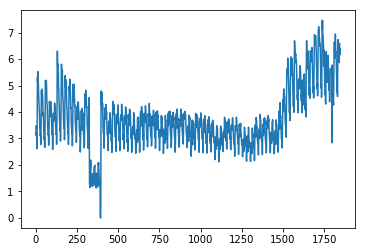

In [8]:
plt.plot(df_train['W'][:])
plt.show()

In [9]:
df_train['W'][326:393].mean()

1.5103111618364438

In [10]:
df_train['W'][326:396] += df_train['W'][0:1500].mean() - df_train['W'][326:393].mean()

/Users/Muks/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


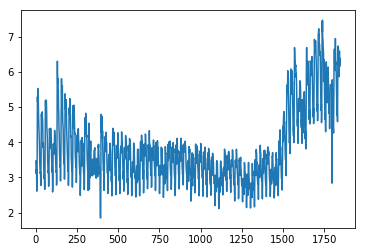

In [11]:
plt.plot(df_train['W'][:])
plt.show()

## Creating training sequences (predicting from previous 7 days' features --> next day)

In [12]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back)]
		dataX.append(a)
		dataY.append(dataset[i + look_back, :, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [13]:
dataset = df_train.values.reshape((-1, 24, 4))

In [14]:
dataset.shape

(77, 24, 4)

In [21]:
X, y = create_dataset(dataset, look_back=7)
X = X.reshape((X.shape[0], 7, -1))

In [22]:
X.shape, y.shape

((70, 7, 96), (70, 24))

In [67]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Input
from keras.callbacks import Callback
from keras.optimizers import adagrad, adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from IPython.display import clear_output

## Setting up LSTM model

In [70]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(100, input_shape=(7 , 24 * 4)))
model.add(Dense(50, activation='relu'))
model.add(Dense(24))

In [71]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 100)               78800     
_________________________________________________________________
dense_9 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_10 (Dense)             (None, 24)                1224      
Total params: 85,074
Trainable params: 85,074
Non-trainable params: 0
_________________________________________________________________


In [73]:
# model.compile(loss='mean_squared_error', optimizer=adagrad(lr=0.01))
model.compile(loss='mean_squared_error', optimizer='adam')

## Spitting Training & Validation Data

In [74]:
num_train = 64
X_train = X[ : num_train]
y_train = y[ : num_train]
X_test = X[num_train : ]
y_test = y[num_train : ]

In [75]:
## From https://gist.github.com/stared/dfb4dfaf6d9a8501cd1cc8b8cb806d2e

class PlotLosses(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

## Training the model, plotting loss curve across epochs

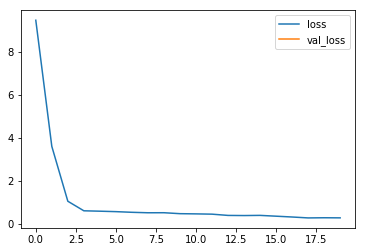

64/64 [==============================] - 0s - loss: 0.2694     


In [76]:
model.fit(X_train, y_train, epochs=20, callbacks=[plot_losses], batch_size=4)

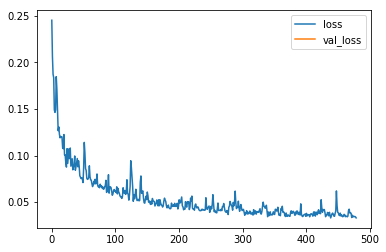

64/64 [==============================] - 0s - loss: 0.0330     


In [77]:
history = model.fit(X_train, y_train, epochs=500, callbacks=[plot_losses], batch_size=4, initial_epoch=21)

In [2]:
# history.history['loss']

## Predictions for the whole dataset

In [86]:
y_pred = model.predict(X)

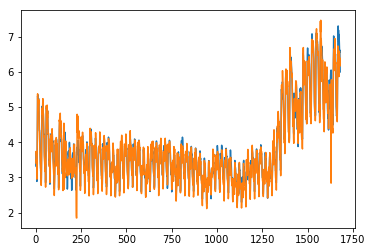

In [87]:
plt.plot(y_pred.flatten()[:])
plt.plot(y.flatten()[:])
plt.show()

## Plots and evaluation for validation data

/Users/Muks/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


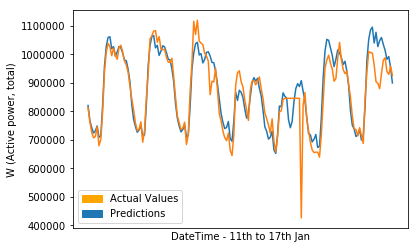

Average rms error =  24036.8776023
Average percentage error =  4.27224236212 %


In [27]:
plt.plot(y_pred[-7:].flatten() * std['W'])
plt.plot(y[-7:].flatten() * std['W'])
plt.axes().get_xaxis().set_ticks([])
orange_patch = mpatches.Patch(color='orange', label='Actual Values')
blue_patch = mpatches.Patch(color='#1f77b4', label='Predictions')
plt.xlabel('DateTime - 11th to 17th Jan')
plt.ylabel('W (Active power, total)')
plt.legend(handles=[orange_patch, blue_patch])
plt.legend()
plt.show()
print("Average rms error = ", 24036.8776023)
print("Average percentage error = ", 0.0427224236212 * 100,  "%")

In [39]:
rmse_test = model.evaluate(X_test, y_test)
print(rmse_test * std['W'])
print(rmse_test * std['W']/562629.0730947304)

6/6 [==============================] - 0s
24036.8776023
0.0427224236212


In [113]:
model.save_weights('best_model_4th_feb_3:30pm')

## Generating predictions for the next 7 days

In [92]:
testData = df_test.values

In [93]:
testData.shape

(264, 3)

### Test data contains only temperature & isWeekend features, as W (load) is generated day-by-day

In [94]:
testData

array([[ 3.4,  1.4,  0. ],
       [ 3.4,  1.4,  0. ],
       [ 3.4,  1.4,  0. ],
       [ 3.4,  1.4,  0. ],
       [ 3.4,  1.4,  0. ],
       [ 3.4,  1.4,  0. ],
       [ 3.4,  1.4,  0. ],
       [ 3.4,  1.4,  0. ],
       [ 3.4,  1.4,  0. ],
       [ 3.4,  1.4,  0. ],
       [ 3.4,  1.4,  0. ],
       [ 3.4,  1.4,  0. ],
       [ 3.4,  1.4,  0. ],
       [ 3.4,  1.4,  0. ],
       [ 3.4,  1.4,  0. ],
       [ 3.4,  1.4,  0. ],
       [ 3.4,  1.4,  0. ],
       [ 3.4,  1.4,  0. ],
       [ 3.4,  1.4,  0. ],
       [ 3.4,  1.4,  0. ],
       [ 3.4,  1.4,  0. ],
       [ 3.4,  1.4,  0. ],
       [ 3.4,  1.4,  0. ],
       [ 3.4,  1.4,  0. ],
       [ 3.8,  1.6,  0. ],
       [ 3.8,  1.6,  0. ],
       [ 3.8,  1.6,  0. ],
       [ 3.8,  1.6,  0. ],
       [ 3.8,  1.6,  0. ],
       [ 3.8,  1.6,  0. ],
       [ 3.8,  1.6,  0. ],
       [ 3.8,  1.6,  0. ],
       [ 3.8,  1.6,  0. ],
       [ 3.8,  1.6,  0. ],
       [ 3.8,  1.6,  0. ],
       [ 3.8,  1.6,  0. ],
       [ 3.8,  1.6,  0. ],
 

In [95]:
X_prev = X[-1:]
y_prev = model.predict(X_prev)

In [96]:
y_prev.shape

(1, 24)

In [97]:
i = 0
# testData[i*24: (i+1)*24].shape
y_prev = model.predict(X_prev)
y_prev.T.shape

(24, 1)

In [98]:
testData[i*24: (i+1)*24].shape

(24, 3)

In [106]:
X_add = np.concatenate((y_prev.T, testData[i*24: (i+1)*24]), axis=1).reshape((1, 1, 24 * 4))

In [107]:
X_add.shape

(1, 1, 96)

In [108]:
X_prev[:, 1:].shape

(1, 6, 96)

In [109]:
np.concatenate((X_prev[:, 1:], X_add), axis=1).shape

(1, 7, 96)

### For every day, data from the previous 7 days (including predictions) are used dynamically

In [74]:
to_predict = 11
X_prev = X[-1:]
preds = []
for i in range(to_predict):
    y_prev = model.predict(X_prev)
    preds.append(y_prev)
    X_add = np.concatenate((y_prev.T, testData[i*24: (i+1)*24]), axis=1).reshape((1, 1, 24 * 4))
    X_prev = np.concatenate((X_prev[:, 1:], X_add), axis=1)

In [75]:
preds = np.asarray(preds).flatten()

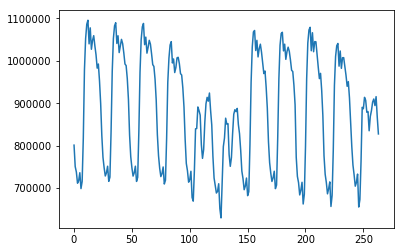

In [79]:
preds = preds * std['W']
plt.plot(preds)
plt.show()

## Dumping generated predictions into a csv

In [97]:
s = "Date,Time,\"W (Active power, total)\"\n"
for i in range(17, 27 + 1):
    date = str(i) + "-01-2018"
    for j in range(24):
        time = "%02d:00:00" %(j)
        s += date + "," + time + "," + str("%0.4f") % (preds[(i - 17) * 24 + j]) + "\n"

In [99]:
with open("hourly_predictions.csv", "w") as f:
    f.write(s)